In [1]:
import os
import torch
import numpy as np
import tempfile
from contextlib import nullcontext


from mast3r.demo import get_args_parser, main_demo, get_reconstructed_scene, set_scenegraph_options
from dust3r.utils.device import to_numpy

from mast3r.cloud_opt.sparse_ga import sparse_global_alignment

from mast3r.model import AsymmetricMASt3R
from mast3r.utils.misc import hash_md5

import mast3r.utils.path_to_dust3r  # noqa
from dust3r.demo import set_print_with_timestamp

import matplotlib.pyplot as plt

import os
from scipy.io import savemat
import argparse

import sys
sys.path.append("/home/manuelf/tapnet")

%load_ext autoreload
%autoreload 2

/home/manuelf/mast3r/dust3r/dust3r/cloud_opt/base_opt.py:278: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [4]:
from dust3r.utils.image import load_images
import copy

outdir = "./output"
device = "cuda:0"
#device = "cpu"
#im_dir = "./images_in/piv"
#im_dir = "./images_in/train"
#im_dir = "./images_in/DAVIS/JPEGImages/480p/train"
#im_dir = "./images_in/DAVIS/JPEGImages/480p/car-roundabout"
#im_dir = "./images_in/DAVIS/JPEGImages/480p/bus"
#im_dir = "./images_in/jpc_desk"
#im_dir = "./images_in/cozinha_segment"
im_dir = "./images_in/apple"

#make filelist be a list of all the files in the directory
#filelist = [os.path.join(filelist, f) for f in os.listdir(filelist)]
#print(filelist)

#load images

imgs = load_images(im_dir, size=512, verbose=1, skip_frames=0, ground_truth=False)
filelist = [img["path"] for img in imgs]

if len(imgs) == 1:
        imgs = [imgs[0], copy.deepcopy(imgs[0])]
        imgs[1]['idx'] = 1
        filelist = [im_dir[0], im_dir[0] + '_2']
        

#imgs = imgs[:14]

>> Loading images from ./images_in/apple
 - adding 00000.png with resolution 1296x720 --> 512x272
 - adding 00001.png with resolution 1296x720 --> 512x272
 - adding 00002.png with resolution 1296x720 --> 512x272
 - adding 00003.png with resolution 1296x720 --> 512x272
 - adding 00004.png with resolution 1296x720 --> 512x272
 - adding 00005.png with resolution 1296x720 --> 512x272
 - adding 00006.png with resolution 1296x720 --> 512x272
 - adding 00007.png with resolution 1296x720 --> 512x272
 - adding 00008.png with resolution 1296x720 --> 512x272
 - adding 00009.png with resolution 1296x720 --> 512x272
 - adding 00010.png with resolution 1296x720 --> 512x272
 - adding 00011.png with resolution 1296x720 --> 512x272
 - adding 00012.png with resolution 1296x720 --> 512x272
 - adding 00013.png with resolution 1296x720 --> 512x272
 - adding 00014.png with resolution 1296x720 --> 512x272
 - adding 00015.png with resolution 1296x720 --> 512x272
 - adding 00016.png with resolution 1296x720 --

In [5]:
# IMPORT TAPNEXT 
from tapnet.tapnext.tapnext_torch import TAPNext
from tapnet.tapnext.tapnext_torch_utils import restore_model_from_jax_checkpoint

def init_tapnext():

  tapnext = TAPNext(image_size=(256, 256)).to(device)

  #set model to eval, not backprop
  tapnext.eval()
  for p in tapnext.parameters():
    p.requires_grad = False

  tapnext = restore_model_from_jax_checkpoint(tapnext, "/home/manuelf/tapnet/tapnet/tapnext/tapnet/checkpoints/bootstapnext_ckpt.npz")

  return tapnext

tapnext = init_tapnext()

/home/manuelf/miniconda3/envs/mast3r/lib/python3.11/site-packages/torch/_export/utils.py:415: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _register_pytree_node(


In [3]:
model = AsymmetricMASt3R.from_pretrained("./docker/files/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth").to(device)
#model = AsymmetricMASt3R.from_pretrained("./docker/files/checkpoints/MonST3R_PO-TA-S-W_ViTLarge_BaseDecoder_512_dpt.pth").to(device)

... loading model from ./docker/files/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


len of pairs 130


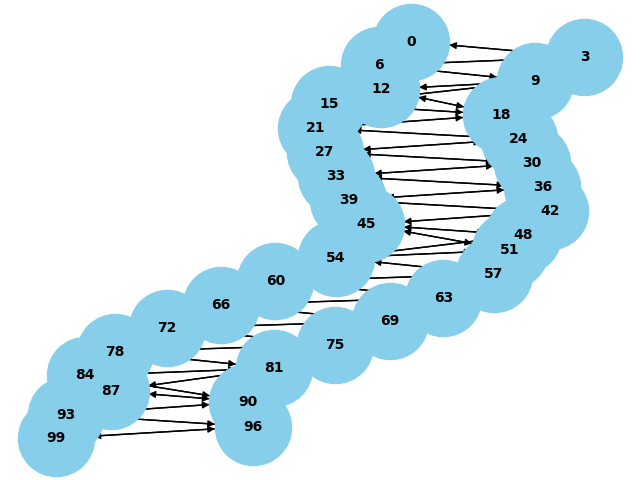

In [ ]:
%matplotlib widget

#test make_pairs
from dust3r.image_pairs import make_pairs
from auxiliar.viz_graph import viz_graph

#scenegraphy
scenegraph_type="swin"
win_cyclic = False
winsize = 2
refid = 0

scene_graph_params = [scenegraph_type]
if scenegraph_type in ["swin", "logwin"]:
    scene_graph_params.append(str(winsize))
elif scenegraph_type == "oneref":
    scene_graph_params.append(str(refid))
if scenegraph_type in ["swin", "logwin"] and not win_cyclic:
    scene_graph_params.append('noncyclic')
scene_graph = '-'.join(scene_graph_params)

pairs = make_pairs(imgs, scene_graph=scene_graph, prefilter=None, symmetrize=True)
    
print("len of pairs", len(pairs))

file_names = [im["path"] for im in imgs]

plt.figure()
plt.clf()
viz_graph(file_names, pairs)

In [11]:
#MAST3R INFERENCE

from auxiliar.scene_to_data import SceneToData
import time

# cache to store previous inference results
delete_cache = True
if delete_cache:
    os.system(f"rm -rf {outdir}/cache")
cache_dir = os.path.join(outdir, 'cache')
os.makedirs(cache_dir, exist_ok=True)

# optimization level
optim_level = "coarse"
niter2 = 0 if optim_level == "coarse" else 200

scene, _, res_coarse, res_fine = sparse_global_alignment(filelist, pairs, cache_dir,
                                    model, lr1=0.07 , niter1=500, lr2=0.014, niter2=niter2, device=device,
                                    opt_depth='depth' in optim_level, shared_intrinsics=True,
                                    matching_conf_thr=0.5)

#save the scene into mat files and full pcd file with wrld pts
scene_class = SceneToData(scene)
scene_class.save_mat_file(outdir)
scene_class.save_pcd_file(outdir, conf_threshold=0.001)

100%|█████████████████████████████████████████████████████████████████████████| 62/62 [03:05<00:00,  2.99s/it]


Inference time: 20.92s, Correspondences time: 162.15s


100%|█████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.64it/s]
/home/manuelf/miniconda3/envs/mast3r/lib/python3.11/site-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


init focal (shared) =  1551.92


100%|████████████████████████████████████████████████| 500/500 [00:27<00:00, 18.08it/s, lr=0.0000, loss=0.008]


>> final loss = 0.00848664715886116
Final focal (shared) =  1551.92
Optimization took 27.653504371643066 s


In [5]:
# DUST3R ga + MAST3R model
from dust3r.inference import inference
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode
from dust3r.cloud_opt.base_opt import clean_pointcloud
from dust3r.utils.geometry import inv


for pair in pairs:
    continue
    pair[0]["img"][0,:,torch.tensor(pair[0]["gt"]).to(torch.bool)] = 0
    pair[1]["img"][0,:,torch.tensor(pair[1]["gt"]).to(torch.bool)] = 0

output = inference(pairs, model, device, batch_size=1, verbose=True)



>> Inference with model on 62 image pairs


  0%|                                                                                  | 0/62 [00:00<?, ?it/s]/home/manuelf/mast3r/dust3r/dust3r/inference.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/manuelf/mast3r/dust3r/dust3r/model.py:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/manuelf/mast3r/dust3r/dust3r/inference.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|█████████████████████████████████████████████████████████████████████████| 62/62 [00:21<00:00,  2.85it/s]


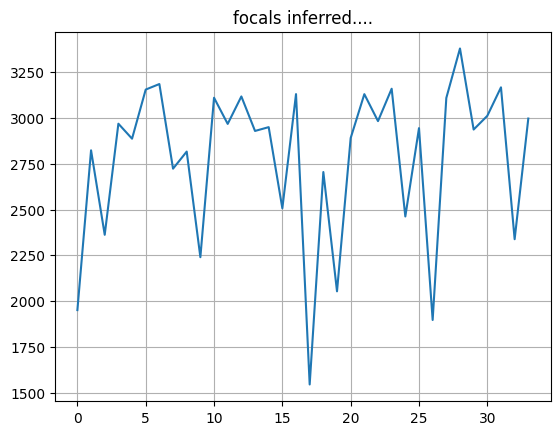

In [94]:
%matplotlib inline
from dust3r.post_process import estimate_focal_knowing_depth 

focals = np.array([estimate_focal_knowing_depth(output["pred2"]["pts3d_in_other_view"][idx_pair,:,:,:].unsqueeze(0).to(device) ,\
                                                (torch.tensor( imgs[0]["img"].shape[2:] ) / 2).to(device) , focal_mode='weiszfeld').cpu()
                                                for idx_pair in range(len(pairs))])

plt.clf()
plt.plot(focals)
plt.title("focals inferred....")
plt.grid()
plt.show()

In [6]:

mode = GlobalAlignerMode.PointCloudOptimizer if len(imgs) > 2 else GlobalAlignerMode.PairViewer
init_mode = "mst" if len(imgs) > 2 else "known_poses"

scene = global_aligner(output, device=device, mode=mode, verbose=True)

loss = scene.compute_global_alignment(init=init_mode, niter=200, schedule="cosine", lr=0.01)

# better confs
cleaned_confs = clean_pointcloud(scene.get_conf(), scene.get_intrinsics(), inv(scene.get_im_poses()), scene.get_conf(), scene.get_pts3d())

 init edge (15*,13*) score=np.float64(846.4273071289062)
 init edge (14*,13) score=np.float64(822.9947509765625)
 init edge (14,12*) score=np.float64(803.5235595703125)
 init edge (13,11*) score=np.float64(786.43798828125)
 init edge (16*,14) score=np.float64(782.5677490234375)
 init edge (12,10*) score=np.float64(767.8903198242188)
 init edge (11,9*) score=np.float64(665.019775390625)
 init edge (10,8*) score=np.float64(599.926025390625)
 init edge (9,7*) score=np.float64(543.0913696289062)
 init edge (8,6*) score=np.float64(390.687255859375)
 init edge (7,5*) score=np.float64(335.88848876953125)
 init edge (6,4*) score=np.float64(254.517578125)
 init edge (5,3*) score=np.float64(174.25259399414062)
 init edge (4,2*) score=np.float64(123.05252075195312)
 init edge (3,1*) score=np.float64(61.84408950805664)
 init edge (2,0*) score=np.float64(26.70553207397461)
forces setting depthmaps
forces setting depthmaps
forces setting depthmaps
forces setting depthmaps
forces setting depthmaps
fo

100%|████████████████████████████████████████| 200/200 [00:19<00:00, 10.33it/s, lr=1.61678e-06 loss=0.0267663]


# just check what is the output of just one pair

### Non symmetric inference, just one branch of the network without the cross-attention

In [ ]:
from auxiliar.func_aux import rerun_wlrd

cat_3d_clr = rerun_wlrd(scene, imgs, mode="dust3r", conf_thresh=0.2)

In [ ]:
from dust3r.post_process import estimate_focal_knowing_depth 
import cv2 as cv
from tqdm import tqdm

# estimate focal lenght for each pair and the pairwise transformation

idx_pair = 0
tfs = {}

for idx_pair, pair in tqdm(enumerate(pairs),total=len(pairs), ncols=100):   

    #print("between img", pair[0]["instance"], pair[1]["instance"])
    H, W = torch.tensor(pair[0]["img"].shape[2:] )
    pp = torch.tensor([W / 2, H / 2]).to(device)

    focal_length = estimate_focal_knowing_depth(output["pred2"]["pts3d_in_other_view"][idx_pair,:,:,:].unsqueeze(0).to(device) ,\
                                                 pp, focal_mode='weiszfeld')

    K = np.eye(3)
    K[0, 0] = focal_length
    K[1, 1] = focal_length
    K[0, 2] = pp[0]
    K[1, 2] = pp[1]

    #k_global = scene.get_intrinsics()[int(pair[1]["idx"])].detach().cpu().numpy()

    #print(k_global, K)

    #solve the pnp
    pixels = np.mgrid[:int(W), :int(H)].T.astype(np.float32)
    status, R, T, inliers = cv.solvePnPRansac( output["pred2"]["pts3d_in_other_view"][idx_pair,:,:,:].numpy().reshape(-1, 3), \
                                                pixels.reshape(-1,2), K, None, flags=cv.SOLVEPNP_EPNP)   
    
    rot_mat = cv.Rodrigues(R)[0]
    t_vec = T

    if pair[1]["idx"] not in tfs:
        tfs[pair[1]["idx"]] = {}

    tfs[pair[1]["idx"]][pair[0]["idx"]] = np.vstack(( np.hstack((rot_mat, t_vec)), np.array([0, 0, 0, 1]) ))
    
    # REPROJECTION OF 3D POINTS FROM THE FIRST IMAGE TO THE SECOND IMAGE WITH [R|T]
    if np.abs(pair[0]["idx"] - pair[1]["idx"])>=7 and 0:
        #with a known R and T, reproject back the 3d points into the image
        reprojected = cv.projectPoints(output["pred1"]["pts3d"][idx_pair,:,:,:].numpy().reshape(-1, 3), R, T, K, None)[0]

        # create new image with reprojected points in 2d plane

        img = np.zeros((int(H), int(W), 3), dtype=np.float32)

        #saturate to image size values
        reprojected = np.clip(reprojected, 0, np.array([W-1, H-1]))

        img[reprojected.squeeze().astype(int)[:,1], reprojected.squeeze().astype(int)[:,0], :] = pair[0]["img"].squeeze().permute(1,2,0).cpu().numpy()[reprojected.squeeze().astype(int)[:,1], reprojected.squeeze().astype(int)[:,0], :]

        img = img + 1
        img = img / 2
        img = img * 255
        img = img.astype(np.uint8)

        cv.imwrite(f"test_images/{idx_pair}.png", cv.cvtColor((img*0.8).astype(np.uint8) + (0.2*((pair[0]["img"].squeeze().permute(1,2,0)+1)/2*255).numpy()).astype(np.uint8), cv.COLOR_BGR2RGB ))

100%|███████████████████████████████████████████████████████████████| 58/58 [00:18<00:00,  3.14it/s]


In [ ]:
from auxiliar.func_aux import rerun_pairs
rerun_pairs(pairs, tfs, imgs)


In [ ]:
from shapely.geometry import Polygon, Point
H, W = (imgs[0]["img"].shape[2:] )

pts =  [[224, W], [141, 277], [187, 70], [339, 124], [461, 180],[510, 323], [W,H] ]

#plt.imshow(tensor_to_cv2(imgs[0]["img"]))

pgon = Polygon(pts)

pgon.contains(Point(400,400))

step = 10
grid_x, grid_y = np.meshgrid(np.arange(0, W, step), np.arange(0, H, step))

# check if points are inside the polygon in a for loop
querry_pts = []
for x, y in zip(grid_x.flatten(), grid_y.flatten()):
    if pgon.contains(Point(x, y)):
        querry_pts.append([x, y])
        #print("inside", x, y)
    else:
        pass
        #print("outside", x, y)


queries=torch.tensor(querry_pts)
queries = torch.hstack( (torch.zeros(queries.shape[0], 1), queries) )
queries.shape

In [ ]:
from tqdm import tqdm
#use cotracker to generate some tracks

import gc
gc.collect()

#load model
if 'cotracker_model' not in globals():
    cotracker_model = torch.hub.load("facebookresearch/co-tracker", "cotracker3_online",
                                     ).to(device)
    
grid_size = 20
two_frame_tensor = torch.cat([img["img"] for img in imgs], dim=0).unsqueeze(0).to(device) # 1, time, 3, H, W
#two_frame_tensor = video_tensor.permute(0,1,4,2,3)
if 0:
    pred_tracks, pred_visibility = cotracker_model(two_frame_tensor, queries=queries[None].to(device))
elif 0:
    pred_tracks, pred_visibility = cotracker_model(two_frame_tensor, grid_size=grid_size)
else:

    # set model window len to 1 frame
    cotracker_model.step = 8
    #create a grid of points
    step = 30
    ys, xs = np.meshgrid(np.linspace(8, two_frame_tensor.shape[3], step), np.linspace(8, two_frame_tensor.shape[4], step))
    ys = ys.flatten()
    xs = xs.flatten()

    query_points_initial = torch.tensor(
        np.stack(
        [np.zeros(len(xs.flatten())), xs.flatten(), ys.flatten()], axis=1
        )[None],dtype=torch.float32)
    
    cotracker_model(video_chunk=two_frame_tensor, is_first_step=True, queries=query_points_initial.to(device))
    # nesta run faz apenas o resize das queries

    for ind in tqdm(range(0, two_frame_tensor.shape[1] - cotracker_model.step, cotracker_model.step)):

        # 1o chunk 0 - 16
        cotracker_model.queries = torch.cat((query_points_initial, 
                            torch.tensor([[[ind + 1, 10, 10]]])),dim = 1).to(device)
        
        print("added query at", ind + 1)
        #print(cotracker_model.queries)
        pred_tracks, pred_visibility = cotracker_model(
            video_chunk=two_frame_tensor[:, ind : ind + cotracker_model.step * 2],
            #queries=torch.cat((query_points_initial, 
            #                   torch.tensor([[[ind, 10, 10]]])),dim = 1).to(device)
        )  # B T N 2,  B T N 1


pred_tracks_cpu = pred_tracks.cpu() # 1, time, N, 2


In [102]:
# use tapnext to do the tracking
import mediapy

model_video_size = (256, 256)
video = [img["img"].squeeze().permute(1,2,0) for img in imgs] # change to HWChannels
video_resized = mediapy.resize_video(video, model_video_size)


# queries in original image size
step = 20
ys, xs = np.meshgrid(np.linspace(8, video[0].shape[0]-step, step), np.linspace(8, video[0].shape[1]-step, step))
query_points_initial = torch.tensor(
    np.stack(
    [np.zeros(len(xs.flatten())), xs.flatten(), ys.flatten()], axis=1
)[None],dtype=torch.float32).to(device)

#resize the query points to the model size
query_points_initial[0, :, 1:3] /= torch.tensor([video[0].shape[1] / model_video_size[0], video[0].shape[0] / model_video_size[1]]).to(device)

video_tensor_original = torch.cat([torch.tensor(frame).unsqueeze(0) for frame in video]).unsqueeze(0).to(device) # 1, time, H, W, 3
video_tensor_resized = torch.cat([torch.tensor(frame).unsqueeze(0) for frame in video_resized]).unsqueeze(0).to(device) # 1, time, H, W, 3

/tmp/ipykernel_74300/3421212251.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  video_tensor_original = torch.cat([torch.tensor(frame).unsqueeze(0) for frame in video]).unsqueeze(0).to(device) # 1, time, H, W, 3


In [103]:
import time

def add_new_tracks(tracks_step, query_pts ):
  """
    Add new tracks to parts of the query points that are not being covered
    by the current tracks.
    
    Args:
      tracks_step: tensor of shape (1, time, N, 2) with the current tracks
      visible_logits_step: tensor of shape (1, time, N, 2) with the visibility logits
      query_pts: tensor of shape (1, N, 3) with the query points in the original image size
  Returns:
      new_tracks: tensor of shape (1, time, M, 2) with the new tracks
  """

  start = time.time()
  # find the points that are not covered by the current tracks
  covered_points = torch.zeros(query_pts.shape[1], dtype=torch.bool, device=query_pts.device)
  trakcs_to_add = []

  for i in range(query_pts.shape[1]):
    # check if the query point is close to the track point
    dist = torch.norm(query_pts[0, i, 1:3] - tracks_step[0, 0, :, :], dim=1)
    if (dist < 20).sum() > 0: # if there is one track point within 10 pixels, consider it covered
      covered_points[i] = True

  new_query_pts = query_pts[0, ~covered_points, :].unsqueeze(0)  # shape (1, M, 3)

  #print(f"Time to find new query points: {time.time() - start:.2f} seconds")
  if new_query_pts.shape[1] == 0:
    # no new points to track
    return None  
  else:
    return new_query_pts
  


In [ ]:
## TAPNEXT inference
from tqdm import tqdm

tracks_list = []
tracks_logits_list = []
visible_logits_list = []

with torch.no_grad():
  with torch.amp.autocast('cuda', dtype=torch.float32, enabled=True):
    
    tracks, tracks_logits, visible_logits, tracking_state = tapnext(video=video_tensor_resized[:, :1], query_points=query_points_initial)

    tracks_list.append(tracks.cpu())
    tracks_logits_list.append(tracks_logits.cpu())
    visible_logits_list.append(visible_logits.cpu())

    #go over frame by frame
    for k in tqdm(range(1, video_tensor_resized.shape[1])): # skip 1st frame
      
      tracks_step, tracks_logits_step, visible_logits_step, tracking_state = tapnext(
          video=video_tensor_resized[:, k : k + 1],
          state=tracking_state)
      
      # monitor if new tracks need to be added
      new_tracks = add_new_tracks(tracks_step, query_points_initial) # 1, #feats, 3
      
      if new_tracks != None: 
        if new_tracks.shape[1] > 30: # reinitialize the tracker with the new tracks

          print(new_tracks.shape[1])
          
          new_tracks[0, :, 0] = 0 # set the feature time to k

          #create a new tapnext object
          concat_tracks = torch.cat((
                      torch.cat((torch.zeros((1,tracks_list[-1].squeeze(0)[:, (visible_logits_list[-1].squeeze().cpu() > 0), :].shape[1],1)),
                                  tracks_list[-1].squeeze(0)[:, (visible_logits_list[-1].squeeze().cpu() > 0), :]), dim=2).cuda(),
                      new_tracks), dim=1)
          
          tracks_step, tracks_logits_step, visible_logits_step, tracking_state = tapnext(
              video=video_tensor_resized[:, k ].unsqueeze(0), # at frame k
              query_points=concat_tracks)

          tracks_step, tracks_logits_step, visible_logits_step, tracking_state = tapnext(
              video=video_tensor_resized[:, k : k + 1], # recompute new_tracks from k to k+1
              state=tracking_state)
        
          new_tracks = add_new_tracks(tracks_step, query_points_initial) # 1, #feats, 3
          if new_tracks != None: print(new_tracks.shape[1])

      if k == 25:
        break

      tracks_list.append(tracks_step.cpu())
      tracks_logits_list.append(tracks_logits_step.cpu())
      visible_logits_list.append(visible_logits_step.cpu())

 49%|████▉     | 24/49 [00:03<00:04,  5.76it/s]

31


 49%|████▉     | 24/49 [00:03<00:03,  7.56it/s]


In [111]:

#concatenate the tracks, but since they don't habe the same size in dimension 2, add NaN to the of the lines
max_dim = max([t.shape[2] for t in tracks_list])
pad_tracks = lambda tracks_list: [
  torch.cat(( track,
      torch.full(
        (track.shape[0], track.shape[1], max_dim - track.shape[2], track.shape[3]),
        torch.nan,
      ),
    ),
    dim=2,
  )
  for track in tracks_list
]

new_tracks_lists = pad_tracks(tracks_list)

pred_tracks_cpu = torch.cat(new_tracks_lists, dim=1) # 1, time, N, 2
pred_tracks_cpu = pred_tracks_cpu[:, :, :, [1, 0]]

# scale back the points to the original image size
pred_tracks_cpu[:, : ,:,  :] *= torch.tensor([video[0].shape[1] / model_video_size[0], video[0].shape[0] / model_video_size[1]])

#tracks_logits = pad_tracks(tracks_logits_list) # 1, time, N, 2
visible_logits = pad_tracks(visible_logits_list) # 1, time, N, 1
visible_logits = torch.cat(visible_logits, dim=1) # 1, time, N, 1

torch.cuda.empty_cache()

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(video_tensor_resized[:, k ].squeeze(0).cpu())
plt.scatter(new_tracks[0, :, 1].cpu(), new_tracks[0, :, 2].cpu(),marker="x", c='r', s=40, label='new tracks')
plt.scatter(tracks_step[0,0,:,0].cpu(), tracks_step[0,0,:,1].cpu(), c='b', s=20, label='existing tracks')
#plt.scatter(tracks[0,0,:,0].cpu(), tracks[0,0,:,1].cpu(), c='b', s=10, label='start tracks')
plt.scatter(concat_tracks[0, :, 1].cpu(), concat_tracks[0, :, 2].cpu(), c='g', s=10, label='concat tracks')
plt.legend()

In [113]:
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

#cpu copy of pred_tracks
if 0: # cotracker
    pred_tracks_cpu = pred_tracks_cpu
    images_track_cpu = torch.clip( two_frame_tensor.cpu(), min=-1, max=1)
    pred_visibility_cpu = pred_visibility.detach().cpu()
else:
    #pred_tracks_cpu = pred_tracks_cpu
    images_track_cpu = torch.clip( video_tensor_original.permute(0,1,4,2,3).cpu(), min=-1, max=1)
    pred_visibility_cpu = visible_logits.cpu() > 0

print("got here")
def generate_frame_image(frame):
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Show current frame image
    frame_img = (images_track_cpu[0, frame].permute(1, 2, 0).numpy() + 1) / 2
    ax.imshow(frame_img)
    
    # Plot tracks up to current frame
    visible_tracks = int(pred_visibility_cpu[0, frame].sum().item())
    for track_idx in range(visible_tracks):
        if pred_visibility_cpu[0, frame, track_idx]:
            # Get track history up to current frame
            if frame < 5:
                track_history = pred_tracks_cpu[0, :frame + 1, track_idx].cpu().numpy()
            else:
                track_history = pred_tracks_cpu[0, frame - 5:frame + 1, track_idx].cpu().numpy()
            
            # Create color gradient from red to blue for track path
            colors = plt.cm.RdYlBu(np.linspace(0, 1, len(track_history)))
            
            # Plot track path with color gradient
            for i in range(len(track_history) - 1):
                ax.plot(track_history[i:i + 2, 0], 
                        track_history[i:i + 2, 1], 
                        color=colors[i], 
                        linewidth=4, 
                        alpha=0.5)
        
            # Plot current point
            ax.plot(track_history[-1, 0], 
                    track_history[-1, 1], 
                    'w.', 
                    markersize=3, 
                    markeredgecolor='black')
    
    ax.set_title(f'Frame {frame}')
    ax.axis('off')
    output_path = f'test_images/tracks_frame_{frame:03d}.png'
    plt.savefig(output_path, bbox_inches='tight')
    plt.close(fig)
    return output_path

# Ensure the output directory exists
os.makedirs("test_images", exist_ok=True)

# Generate images in parallel
frames = range(0,pred_tracks_cpu.shape[1])
with ProcessPoolExecutor(max_workers=32) as executor:
    list(tqdm(executor.map(generate_frame_image, frames), total=len(frames)))

got here


100%|██████████| 25/25 [00:02<00:00,  8.62it/s]


In [33]:
visible_points = torch.all(pred_visibility_cpu.to(torch.int).squeeze(), dim=0).to("cpu")

H, W = (imgs[0]["img"].shape[2:] )

uv_interest = []
depth_interest = []

for idx_frame, pts3d in enumerate( imgs ):
    uv_interest.append( torch.tensor ( pred_tracks_cpu[0,idx_frame,visible_points,:] )) # frames, points_idx, uv

obs_mat = torch.cat(uv_interest, dim=1).T.cpu().numpy()


/tmp/ipykernel_38067/3408875894.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  uv_interest.append( torch.tensor ( pred_tracks_cpu[0,idx_frame,visible_points,:] )) # frames, points_idx, uv


In [34]:
from auxiliar.factorization import marques_factorization

# svd of uv_interest
M,S = marques_factorization(obs_mat)

In [117]:
from tqdm import tqdm

# fill the observation matrix with features that dissapeared from the scene in cotracker

obs_mat.shape
pred_visibility_cpu.shape

obs_missing = torch.zeros( (pred_visibility_cpu.shape[1]*2, pred_visibility_cpu.shape[2]))
obs_missing[:,:] = torch.nan

num_frames = pred_visibility_cpu.shape[1]

for frame in tqdm(range(0, num_frames)): # for each frame
    for track in range(0, pred_visibility_cpu.shape[2]): # for each feature
        if pred_visibility_cpu[0, frame, track] == True:
            obs_missing[frame, track] = pred_tracks_cpu[0, frame, track, 0]
            obs_missing[frame + num_frames, track] = pred_tracks_cpu[0, frame, track, 1]


obs_missing = obs_missing.numpy()


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 77.39it/s]


In [135]:
#check percenatage of missing points
missing = (np.isnan(obs_missing).sum() / (obs_missing.shape[0] * obs_missing.shape[1]))
print("missing", missing*100, "%")

from auxiliar.mat_compl import alternating_matrix_completion
M_completed = alternating_matrix_completion(obs_missing, verbose=True)[0]

#factorize missed cotracker features
_, S_missed = marques_factorization(M_completed)

missing 20.585 %


  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:04, 20.95it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:02, 35.27it/s]


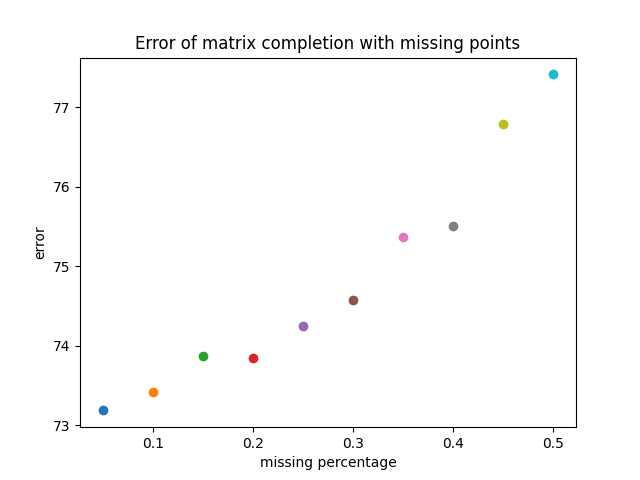

In [125]:
# from the non missing matrix, delete randomly 10% of the points

def delete_random_points(mat, percentage):
    rows, cols = mat.shape
    total_entries = rows * cols
    num_nan = int(total_entries * percentage)

    # Choose random indices
    flat_indices = np.random.choice(total_entries, size=num_nan, replace=False)
    row_indices, col_indices = np.unravel_index(flat_indices, (rows, cols))

    # Set the selected entries to NaN
    mat[row_indices, col_indices] = np.nan

    return mat

#change percentage of points to nan
plt.figure()
for missing in np.linspace(0.05, 0.5, 10):

    obs_nan = delete_random_points(obs_mat.copy(), missing)
    M_completed, error_mask = alternating_matrix_completion(obs_nan, max_iters=100)

    #calculate error with full matrix
    error = np.linalg.norm(obs_mat - M_completed, ord='fro')
    

    #plt.plot(error_mask, label=f"missing {missing:.2f}")
    plt.scatter(missing, error)
    
plt.xlabel("missing percentage")
plt.ylabel("error")
plt.title("Error of matrix completion with missing points")
plt.show()

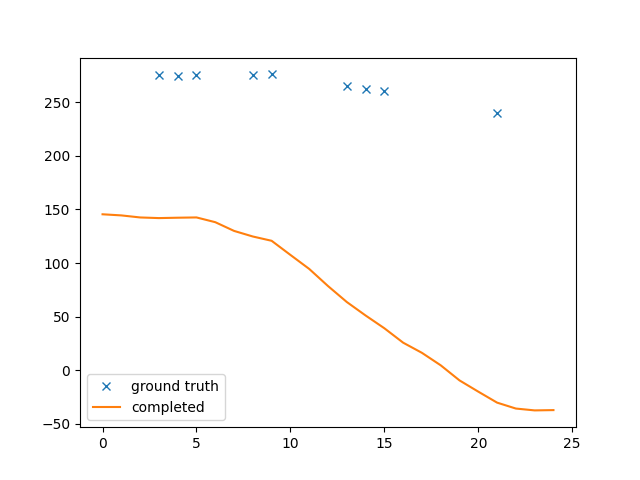

In [130]:
%matplotlib widget

plt.figure()
idx = np.random.randint(0, obs_nan.shape[1])
plt.plot(obs_nan[0:num_frames:2,idx],"x", label="ground truth")
plt.plot(M_completed[0:num_frames:2,idx], label="completed")
plt.legend()
plt.show()

In [32]:
%matplotlib widget
import rerun as rr


rr.init("factorization")
rr.notebook_show(width=int(1920*0.75), height=int(1080*0.75))

# 
#rr.log("completed ", rr.Points3D(marques_factorization(M_completed)[1].T))

rr.log("ground_truth", rr.Points3D(marques_factorization(obs_mat.copy())[1].T))


Viewer()

In [103]:
from sea_raft.core.raft import RAFT
from sea_raft.config.parser import json_to_args
from torchsummary import summary
from sea_raft.core.utils.utils import load_ckpt

import cv2 as cv

raft = RAFT(json_to_args("./sea_raft/config/eval/spring-M.json")).to(device)
load_ckpt(raft, "sea_raft/Tartan-C-T-TSKH-spring540x960-M.pth")


In [ ]:

flow = raft(im1,
            im2)


plt.imshow (
    torch.norm( flow["final"].squeeze(), dim= 0).detach().cpu().numpy()
)

In [104]:
video_flow = []
for idx_frame, pts3d in enumerate(imgs[0:10]):
    pass

    im1 = imgs[idx_frame-1]["img"].to(device)
    im2 = imgs[idx_frame]["img"].to(device)

    flow = raft(im1, im2)["final"].squeeze().permute(1,2,0)

    #create a pixel grid
    H, W = im1.shape[2:]
    if idx_frame == 0:
        grid = torch.meshgrid([torch.arange(H), torch.arange(W)])
        grid = torch.stack(grid, dim=-1).to(device)

    video_flow.append(flow.detach().cpu().numpy())
    grid = grid + flow
    


to_stack = torch.stack([torch.tensor(flow).squeeze() for flow in video_flow], dim=0)


w = torch.reshape( torch.reshape( to_stack , (to_stack.shape[0], -1, 2) ).permute(2,0,1), (2, -1))

U, S, V = np.linalg.svd(w.detach().cpu().numpy()[:, ::70] )#- obs_mat.mean(dim=0, keepdim=True).detach().cpu().numpy())
plt.plot(S, "-x")



/home/manuelf/miniconda3/envs/mast3r/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 1 has a total capacity of 47.27 GiB of which 15.19 MiB is free. Process 58742 has 31.12 GiB memory in use. Including non-PyTorch memory, this process has 16.14 GiB memory in use. Of the allocated memory 15.59 GiB is allocated by PyTorch, and 362.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
w.shape

torch.Size([2, 442368])

In [ ]:
def track_points(flow_list, seed_points):
    """
    Track given seed points across frames using optical flow fields.

    Parameters:
    - flow_list: List of optical flow fields [flow_t0, flow_t1, ..., flow_tN-1], each of shape (H, W, 2).
    - seed_points: List of (x, y) coordinates to track.

    Returns:
    - tracks: List of lists containing tracked points per seed.
    """
    num_frames = len(flow_list)
    tracks = [[p] for p in seed_points]  # Initialize tracks

    for t in range(num_frames):
        flow = flow_list[t]  # Optical flow at frame t

        for i, track in enumerate(tracks):
            x, y = track[-1]
            h, w = flow.shape[:2]

            # Check if still in bounds
            if 0 <= x < w and 0 <= y < h:
                u, v = flow[int(y), int(x)]  # Get flow vector
                new_x, new_y = x + u, y + v

                # Check bounds again
                if 0 <= new_x < w and 0 <= new_y < h:
                    track.append((new_x, new_y))
                else:
                    break  # Stop tracking if out of bounds
            else:
                break  # Stop tracking if out of bounds

    return tracks

tracks = track_points( video_flow, [(300,200), (200,200), (150,150)])

tracks[2]

[(150, 150),
 (np.float32(168.79733), np.float32(146.1442)),
 (np.float32(169.60985), np.float32(148.49203)),
 (np.float32(170.85275), np.float32(150.60858)),
 (np.float32(172.20033), np.float32(152.89752)),
 (np.float32(173.65622), np.float32(155.13147)),
 (np.float32(175.31445), np.float32(157.48099)),
 (np.float32(177.09181), np.float32(160.30699)),
 (np.float32(179.02832), np.float32(162.8267)),
 (np.float32(180.2581), np.float32(165.1301))]

In [ ]:
def draw_tracks(img, tracks):
    for track in tracks:
        points = np.array(track, dtype=np.int32)
        for i in range(1, len(points)):
            img = cv.line(img, tuple(points[i-1]), tuple(points[i]), (0, 255, 0), 2)
    return img

img = draw_tracks(np.ascontiguousarray( (((imgs[0]["img"].squeeze().permute(1,2,0).detach().cpu().numpy()+1)/2)*255), dtype=np.uint8)
                  , tracks)

